# NYC Condos and Co-ops

Data Source [link](https://nycopendata.socrata.com/data?browseSearch=Condominium+Comparable+Rental+Income&type=datasets&agency=&cat=housing+%26+development&scope=)

Note: Queens co-ops data is the same between 2008/2009 and 2009/2010. An anomaly with the source material.

Note: Neighborhoods shapefiles from http://nyc.pediacities.com/New_York_City_Neighborhoods

In [9]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
from matplotlib import cm
import json

import pandas as pd
import pandasql as sql
import numpy as np

In [10]:
all_condos = [f for f in os.listdir("./") if f.startswith("condo") and f.endswith(".csv")]
all_coops = [f for f in os.listdir("./") if f.startswith("coop") and f.endswith(".csv")]

In [32]:
def read_data(the_file):
    column_dict = {}

    if the_file.endswith("2012.csv"):
        if "condo" in the_file:
            data_df = pd.read_csv(the_file, usecols=range(15))
        else:
            data_df = pd.read_csv(the_file, usecols=range(14))
        
        if the_file.split("_")[2] != "staten":
            for col in data_df.columns:
                new_name = "_".join(col.split(" ")[6:]).lower().replace("est.", "estimated")
                column_dict[col] = new_name

        else:
            for col in data_df.columns:
                new_name = "_".join(col.split(" ")[7:]).lower().replace("est.", "estimated")
                column_dict[col] = new_name
    
    else:
        if "condo" in the_file:
            data_df = pd.read_csv(the_file, usecols=range(12))
        else:
            data_df = pd.read_csv(the_file, usecols=range(11))

        if the_file.split("_")[2] != "staten":
            for col in data_df.columns:
                if "condo" in the_file:
                    new_name = "_".join(col.split(" ")[3:]).lower().replace("est.", "estimated")
                else:
                    new_name = "_".join(col.split(" ")[6:]).lower().replace("est.", "estimated")

                column_dict[col] = new_name

        else:
            for col in data_df.columns:
                if "condo" in the_file:
                    new_name = "_".join(col.split(" ")[4:]).lower().replace("est.", "estimated")
                else:
                    new_name = "_".join(col.split(" ")[7:]).lower().replace("est.", "estimated")

                column_dict[col] = new_name

    data_df["housing_type"] = the_file.split("_")[0]
    data_df = data_df.rename(columns=column_dict)
    data_df["borough"] = the_file.split("_")[2]
    borough_id = {"manhattan":1, "bronx":2, "brooklyn":3, "queens":4, "staten":5}
    data_df["borough_id"] = borough_id[the_file.split("_")[2]]
    data_df["fiscal_year_start"] = the_file.split("_")[3]
    data_df["fiscal_year_end"] = the_file.split("_")[4].split(".")[0]

    return data_df

In [12]:
def reformat_neighborhoods(data_df):
    #These were problematic:
    #CASTLE HILL/UNIONPORT, DOWNTOWN-FULTON MALL vs DOWNTOWN BROOKLYN, MORRISANIA/LONGWOOD,
    #HIGHBRIDGE/MORRIS HEIGHTS, MELROSE/CONCOURSE, MORRIS PARK/VAN NEST, MOTT HAVEN/PORT MORRIS,
    #MOUNT HOPE/MOUNT EDEN, SCHUYLERVILLE/PELHAM BAY, ARROCHAR-SHORE ACRES:SHORE ACRES
    #BEDFORD PARK/NORWOOD, COBBLE HILL-WEST
    
    change_dict = {
        "AIRPORT LA GUARDIA":"LAGUARDIA AIRPORT", "EAST TREMONT":"TREMONT", "CASTLE HILL/UNIONPORT":"CASTLE HILL",
        "BEDFORD STUYVESANT":"BEDFORD-STUYVESANT", "ARROCHAR-SHORE ACRES":"SHORE ACRES",
        "CONCORD-FOX HILLS":"CONCORD", "FLATBUSH-EAST":"EAST FLATBUSH", "FLATBUSH-CENTRAL":"FLATBUSH",
        "FLATBUSH-WEST":"FLATBUSH", "FLATBUSH-LEFFERTS GARDEN":"FLATBUSH", "FLATBUSH-NORTH":"FLATBUSH",
        "FINANCIAL":"FINANCIAL DISTRICT", "FLATIRON":"FLATIRON DISTRICT", "FLUSHING-NORTH":"FLUSHING",
        "FLUSHING-SOUTH":"FLUSHING", "FLUSHING MEADOW PARK":"FLUSHING MEADOWS CORONA PARK",
        "GREAT KILLS":"GREAT KILLS PARK", "GREAT KILLS-BAY TERRACE":"BAY TERRACE, STATEN ISLAND",
        "GREENWICH VILLAGE-CENTRAL":"GREENWICH VILLAGE", "GREENWICH VILLAGE-WEST":"WEST VILLAGE",
        "HARLEM-EAST":"EAST HARLEM", "HARLEM-UPPER":"HARLEM", "HARLEM-CENTRAL":"HARLEM", "HARLEM-WEST":"HARLEM",
        "KEW GARDENS":"KEW GARDENS HILLS", "KINGSBRIDGE HTS/UNIV HTS":"UNIVERSITY HEIGHTS",
        "KINGSBRIDGE/JEROME PARK":"KINGSBRIDGE", "MIDTOWN CBD":"MIDTOWN", "MIDTOWN EAST":"MIDTOWN",
        "MIDTOWN WEST":"HELL'S KITCHEN", "NEW BRIGHTON-ST. GEORGE":"ST. GEORGE", "UPPER EAST SIDE (59-79)":"UPPER EAST SIDE",
        "UPPER EAST SIDE (79-96)":"UPPER EAST SIDE", "UPPER EAST SIDE (96-110)":"UPPER EAST SIDE",
        "UPPER WEST SIDE (59-79)":"UPPER WEST SIDE", "UPPER WEST SIDE (79-96)":"UPPER WEST SIDE", 
        "UPPER WEST SIDE (96-116)":"UPPER WEST SIDE", "WASHINGTON HEIGHTS LOWER":"WASHINGTON HEIGHTS",
        "WASHINGTON HEIGHTS UPPER":"WASHINGTON HEIGHTS", 'WILLIAMSBURG-CENTRAL':"WILLIAMSBURG", 
        'WILLIAMSBURG-EAST':"WILLIAMSBURG", 'WILLIAMSBURG-NORTH':"WILLIAMSBURG", 
        'WILLIAMSBURG-SOUTH':"WILLIAMSBURG", "MORRISANIA/LONGWOOD":"LONGWOOD", 
        "HIGHBRIDGE/MORRIS HEIGHTS":"MORRIS HEIGHTS", "MELROSE/CONCOURSE":"CONCOURSE VILLAGE",
        "MORRIS PARK/VAN NEST":"MORRIS PARK", "MOTT HAVEN/PORT MORRIS":"MOTT HAVEN",
        "MOUNT HOPE/MOUNT EDEN":"MOUNT EDEN", "SCHUYLERVILLE/PELHAM BAY":"PELHAM BAY",
        "COBBLE HILL-WEST":"COBBLE HILL", "BEDFORD PARK/NORWOOD":"NORWOOD", 
        ## These were created by looking up actual maps
        "WEST NEW BRIGHTON":"WEST BRIGHTON", "DOWNTOWN-FULTON MALL":"DOWNTOWN BROOKLYN", 
        "DOWNTOWN-FULTON FERRY":"DOWNTOWN BROOKLYN",
        "BEECHHURST":"BAY TERRACE", "HAMMELS":"ROCKAWAY BEACH", "SO. JAMAICA-BAISLEY PARK":"ST. ALBANS",
        "PELHAM PARKWAY NORTH":"PELHAM GARDENS", "WESTCHESTER":"WESTCHESTER SQUARE",
        "CLINTON":"THEATER DISTRICT", "JAVITS CENTER":"HELL'S KITCHEN", "MANHATTAN VALLEY":"CENTRAL PARK",
        "SOUTHBRIDGE":"TWO BRIDGES"
    }
    
    available_hoods = list(set(data_df.neighborhood))
    
    for key in change_dict.keys():
        if key in available_hoods:
            data_df.neighborhood = data_df.neighborhood.replace(key, change_dict[key])
        
    return data_df


In [33]:
condo_df = read_data(all_condos[0])
for the_file in all_condos[1:]:
    condo_df = pd.concat((condo_df, read_data(the_file)))

In [34]:
coop_df = read_data(all_coops[0])
for the_file in all_coops[1:]:
    coop_df = pd.concat((coop_df, read_data(the_file)))

In [35]:
condo_df = reformat_neighborhoods(condo_df)
coop_df = reformat_neighborhoods(coop_df)

In [36]:
coop_df.columns

Index([u'address', u'boro-block-lot', u'borough', u'borough_id',
       u'building_classification', u'estimated_expense',
       u'estimated_gross_income', u'expense_per_sqft', u'fiscal_year_end',
       u'fiscal_year_start', u'full_market_value', u'gross_income_per_sqft',
       u'gross_sqft', u'housing_type', u'market_value_per_sqft',
       u'neighborhood', u'net_operating_income', u'total_units',
       u'year_built'],
      dtype='object')

In [37]:
# plot bar charts of average fair market value per square foot per borough per year
the_query = "SELECT borough, SUM(market_value_per_sqft) / COUNT(market_value_per_sqft) AS avg_fmv," 
the_query += " fiscal_year_start, borough_id"
the_query += " FROM coop_df"
the_query += " GROUP BY borough, fiscal_year_start"
avg_fmv_per_borough_coop = sql.sqldf(the_query, locals())
avg_fmv_per_borough_coop.fiscal_year_start = avg_fmv_per_borough_coop.fiscal_year_start.astype(int)

the_query = "SELECT borough, SUM(market_value_per_sqft) / COUNT(market_value_per_sqft) AS avg_fmv," 
the_query += " fiscal_year_start, borough_id"
the_query += " FROM condo_df"
the_query += " GROUP BY borough, fiscal_year_start"
avg_fmv_per_borough_condo = sql.sqldf(the_query, locals())
avg_fmv_per_borough_condo.fiscal_year_start = avg_fmv_per_borough_condo.fiscal_year_start.astype(int)

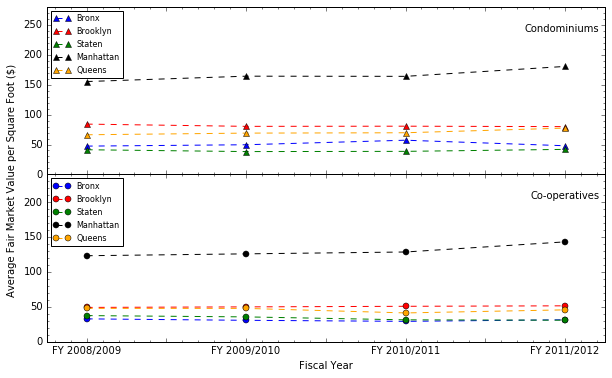

In [43]:
colors = ["b","r","g","k","orange"]
fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(hspace=0)
ax = plt.subplot(211)
boroughs = list(set(avg_fmv_per_borough_condo.borough))
for ii in range(len(boroughs)):
    the_borough = avg_fmv_per_borough_condo.borough == boroughs[ii]
    ax.plot(avg_fmv_per_borough_condo[the_borough].fiscal_year_start, avg_fmv_per_borough_condo[the_borough].avg_fmv, 
            color=colors[ii], marker="^", label=boroughs[ii].capitalize(), linestyle="--")
ax.text(0.99, 0.9, "Condominiums", transform=ax.transAxes, horizontalalignment="right", verticalalignment="top")
ax.legend(fontsize=8, loc="upper left")
ax.set_ylim(0, 280)
ax.set_xlim(2007.75, 2011.25)
ax.set_xticklabels([])
ax.minorticks_on()

fig.text(0.07, 0.5, 'Average Fair Market Value per Square Foot ($)', va='center', rotation='vertical')

ax = plt.subplot(212)
for ii in range(len(boroughs)):
    the_borough = avg_fmv_per_borough_coop.borough == boroughs[ii]
    ax.plot(avg_fmv_per_borough_coop[the_borough].fiscal_year_start, avg_fmv_per_borough_coop[the_borough].avg_fmv, 
            color=colors[ii], marker="o", label=boroughs[ii].capitalize(), linestyle="--")
    
ax.text(0.99, 0.9, "Co-operatives", transform=ax.transAxes, horizontalalignment="right", verticalalignment="top")
ax.legend(fontsize=8, loc="upper left")
ax.set_ylim(0, 240)
ax.set_xlim(2007.75, 2011.25)
ax.set_xticklabels(["", "FY 2008/2009", "", "FY 2009/2010", "", "FY 2010/2011", "", "FY 2011/2012"])
ax.set_xlabel("Fiscal Year")
ax.minorticks_on()
plt.savefig("market_value_sqft.png")
plt.show()

In [39]:
# load in neighborhood shapes
neighborhoods = json.load(open("nyc_neighborhoods_geojson.geojson"))

In [40]:
the_query = "SELECT neighborhood, SUM(gross_income_per_sqft) / COUNT(gross_income_per_sqft) AS avg_gross"
the_query += " FROM coop_df"
# the_query += " WHERE fiscal_year_start = 2011"
the_query += " GROUP BY neighborhood"
coop_hood_avgs = sql.sqldf(the_query, locals())

In [41]:
coop_hood_avgs_trans = coop_hood_avgs.T
coop_hood_avgs_trans.columns = coop_hood_avgs_trans.iloc[0]

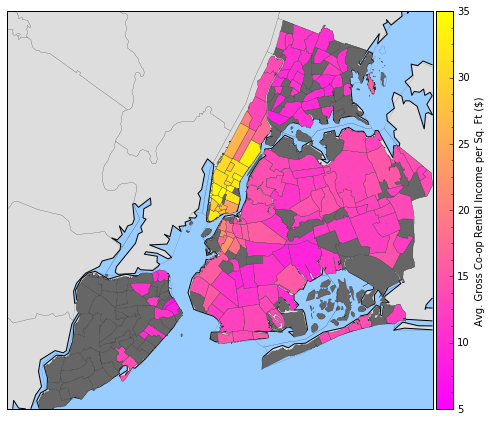

In [44]:
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.01,right=0.9,top=0.97,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)

x1 = -74.3
x2 = -73.7
y1 = 40.5
y2 = 40.925

# setup mercator map projection.
m = Basemap(llcrnrlon=x1,llcrnrlat=y1,urcrnrlon=x2,urcrnrlat=y2,\
            resolution='h',projection='merc',\
            lat_ts=1.)

m.drawcoastlines()
m.fillcontinents(color="#DDDDDD")
m.drawcountries()
m.drawmapboundary(fill_color='#99ccff')
m.drawcounties()
vmin = 5.
vmax = 35.

cmap = plt.cm.spring
for feature in neighborhoods["features"]:
    if feature["properties"]["neighborhood"].upper() in list(coop_hood_avgs.neighborhood):
        hood = feature["properties"]["neighborhood"].upper()
        value = coop_hood_avgs_trans[hood]["avg_gross"]
        color = cmap((value - vmin)/(vmax - vmin))[:3]

    else:
        color = "#666666"

    some_points = feature["geometry"]["coordinates"]
    lons, lats = np.array(some_points).T
    data = np.array(m(lons, lats)).T

    lines = LineCollection(data)

    lines.set_edgecolors("#333333")
    lines.set_facecolors(color)
    lines.set_linewidth(0.3)
    ax.add_collection(lines)
    

ax1 = fig.add_axes([0.83, 0.05, 0.03, 0.92])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation="vertical")
cbar.set_label("Avg. Gross Co-op Rental Income per Sq. Ft ($)")
dtick = 5.
cbar.set_ticks(np.arange(vmin, vmax+dtick, dtick))
cbar.ax.minorticks_on()
plt.savefig("coop_rental_map.png")
plt.show()